In [1]:
SCITSR_PATH = '/home/longhoang01/Developer/table-recognition/data/SciTSR-partition'
MODEL_WEIGHT = '/home/longhoang01/Developer/table-recognition/pret-models/split2.pth'
SAVE_PATH = '/home/longhoang01/Developer/table-recognition/results/split'

In [2]:
import numpy as np
from tqdm import tqdm
import glob
import cv2 as cv

from data_utils.utils import *
from merge.heuristics import *
from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel

In [3]:
# LOAD MODEL
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SplitModel(3)
model = torch.nn.DataParallel(model).to(device)

if device == 'cuda':
    model.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    model.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

device

'cpu'

In [4]:
SUBSET = 'train'
print(f'Loading data for the "{SUBSET}" subset')

# Load images
img_dir = os.path.join(SCITSR_PATH, SUBSET, 'img')
img_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
print(f'- Got {len(img_paths)} images')

# Load Merge labels
merge_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'merge_label.json')
merge_labels = load_json(merge_json)
print(f"- Loaded {len(merge_labels)} labels for Merge module")

# Load Text posisions
chunk_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'chunk_label.json')
chunk_labels = load_json(chunk_json)
print(f"- Loaded texts positions for {len(chunk_labels)} images")

# Load dataset
split_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'split_label.json')
split_labels = load_json(split_json)
dataset = ImageDataset(img_dir, split_labels, 8, scale=1, min_width=10, returns_image_name=True)
print(f'- Loaded dataset with {len(dataset)} examples')

Loading data for the "train" subset
- Got 10000 images
- Loaded 10000 labels for Merge module
- Loaded texts positions for 10000 images
- Loaded dataset with 10000 examples


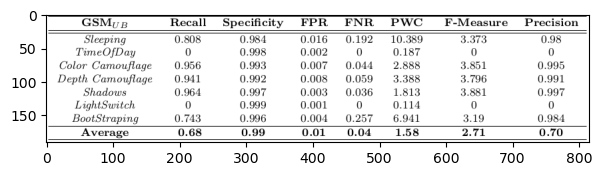

In [5]:
IDX = 0
sample_img = load_image(img_paths[IDX])
view_imgs([sample_img])

In [6]:
img_ready = prep_image(sample_img)

with torch.no_grad():
    r_pred, c_pred = model(img_ready)
r_pred, c_pred = process_split_results(r_pred, c_pred)
r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)

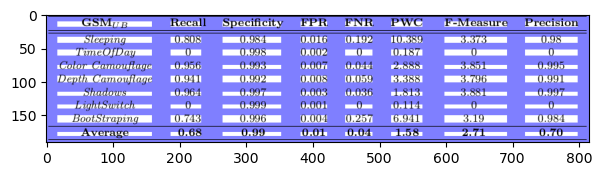

In [7]:
vis_split(sample_img, r_pred, c_pred);

In [8]:
@torch.no_grad
def get_split_results(model: SplitModel, 
                    img_dir: str, 
                    split_json: str
):
    '''
    Get split results as a dictionary for further postprocessing or analysis
    Args:
        model -- Split model
        img_dir -- string, path to image folder of on of train, val, or test set
        split_json -- string, path to json ground truth file for Split module
    Returns:
        res -- dictionary where keys are image names. 
                The value of each key is a dictionary with two keys: 'row' and 'col' which in turn
                contains 3 keys called 'prec', 'rec', and 'f1'
    '''
    # Load dataset
    split_labels = load_json(split_json)
    dataset = ImageDataset(img_dir, split_labels, 8, scale=1, min_width=10, returns_image_name=True)
    print(f'- Loaded dataset with {len(dataset)} examples')

    res = {}
    for img, label, name in tqdm(dataset):
        # ground truth
        r_gt, c_gt = label
        r_gt, c_gt = r_gt.cpu().numpy(), c_gt.cpu().numpy() 

        # prediction
        r_pred, c_pred = model(img.unsqueeze(0))
        r_pred, c_pred = process_split_results(r_pred, c_pred)
        r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)

        # eval on precision, recall, and f1
        r_metrics = eval3(r_pred, r_gt)
        c_metrics = eval3(c_pred, c_gt)
        # print(r_metrics['precision'], r_metrics['recall'], r_metrics['f1'])
        # print(c_metrics['precision'], c_metrics['recall'], c_metrics['f1'])

        # log results
        res[name] = {
            'row': {
                'prec': r_metrics['precision'], 
                'rec': r_metrics['recall'], 
                'f1': r_metrics['f1']
            },
            'col': {
                'prec': c_metrics['precision'], 
                'rec': c_metrics['recall'], 
                'f1': c_metrics['f1']
            }
        }

    return res

In [9]:
# train_res = get_split_results(model, img_dir, split_json)
# write_json(os.path.join(SAVE_PATH, f'split_output_{SUBSET}.json'), train_res)

In [10]:
SUBSET = 'val'
val_img_dir = os.path.join(SCITSR_PATH, SUBSET, 'img')
val_split_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'split_label.json')
val_res = get_split_results(model, val_img_dir, val_split_json)

- Loaded dataset with 1971 examples


  1%|          | 17/1971 [00:12<24:50,  1.31it/s]
/home/longhoang01/Developer/table-recognition/code/deep-split-merge-scitsr/modules/split_modules.py:84: SyntaxWarning: invalid escape sequence '\h'
  """


KeyboardInterrupt: 

In [ ]:
write_json(os.path.join(SAVE_PATH, f'split_output_{SUBSET}.json'), val_res)

In [ ]:
val_res_path = os.path.join(SAVE_PATH, 'split_output_val.json')
val_res = load_json(val_res_path)
len(val_res.keys())

1971

In [ ]:
val_res[list(val_res.keys())[0]]

{'row': {'prec': 1.0, 'rec': 0.9285714285714286, 'f1': 0.962962962962963},
 'col': {'prec': 0.8099547511312217,
  'rec': 0.988950276243094,
  'f1': 0.8905472636815921}}

In [ ]:
def top_n_lowest_f1(data, n):
    row_f1 = sorted(data.items(), key=lambda x: x[1]['row']['f1'])[:n]
    col_f1 = sorted(data.items(), key=lambda x: x[1]['col']['f1'])[:n]
    
    row_keys = [key for key, item in row_f1]
    col_keys = [key for key, item in col_f1]
    
    return row_keys, col_keys

row_names, col_names = top_n_lowest_f1(val_res, 10)

In [11]:
names = ['1801.00693v1.3',
 '1712.03781v2.6',
 '1605.09721v1.1',
 '1804.03343v1.8',
 '1608.04337v2.1',
 '1804.03343v1.6',
 '1303.1872v1.1',
 '1712.00848v1.1',
 '1408.0782v1.3',
 '1808.04525v1.3']

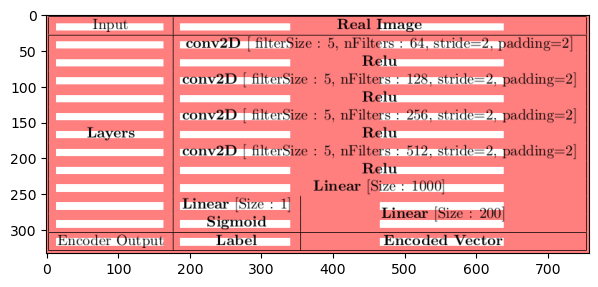

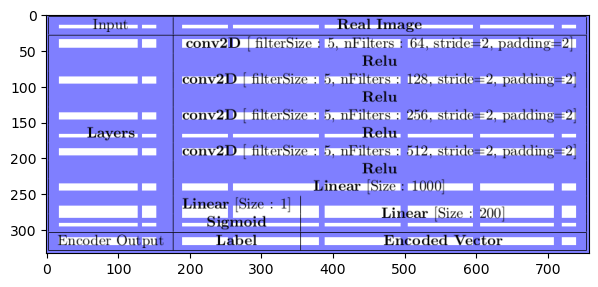

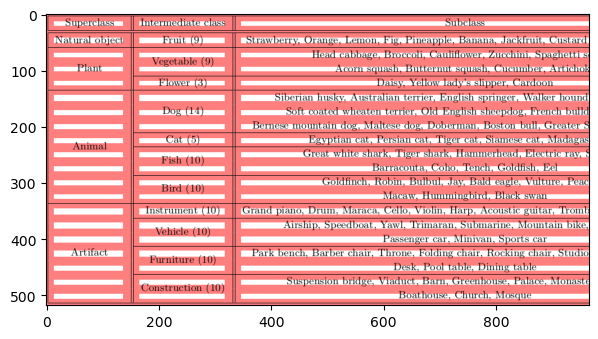

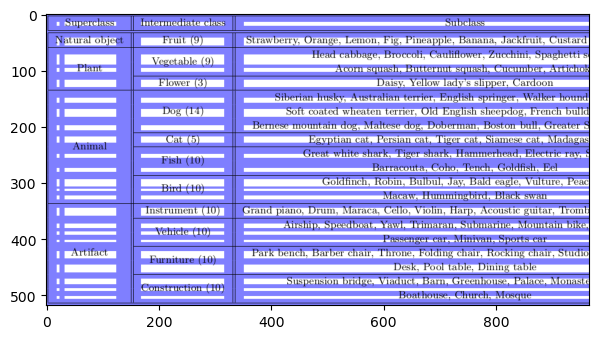

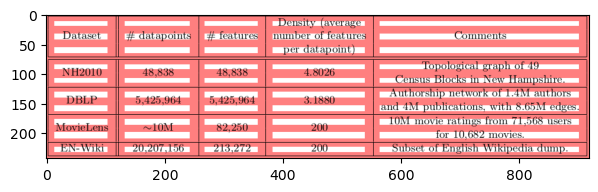

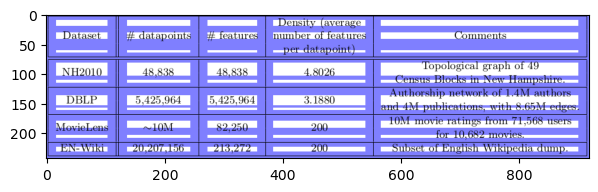

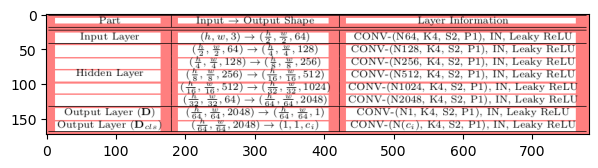

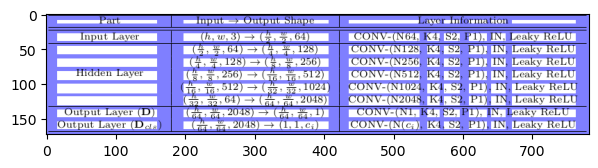

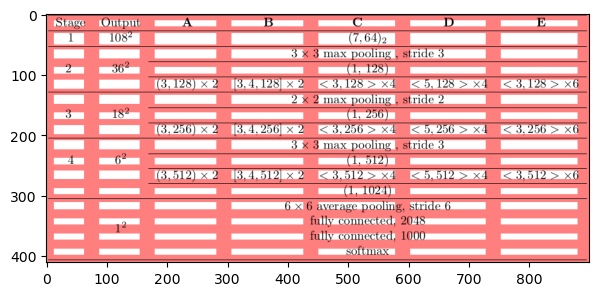

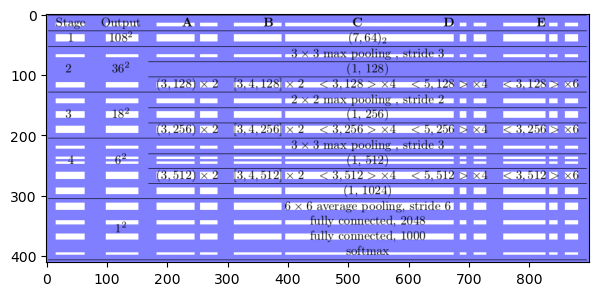

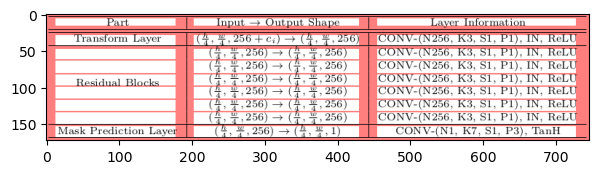

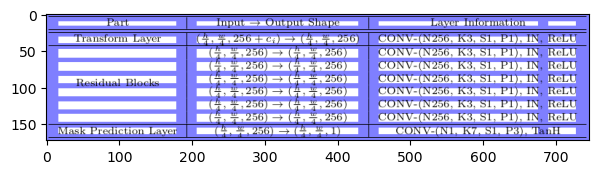

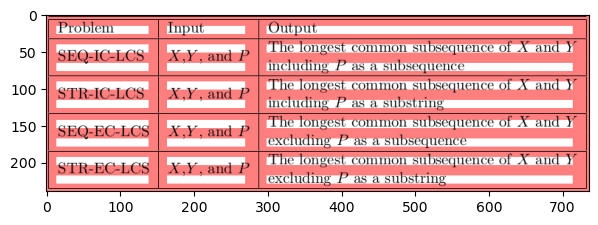

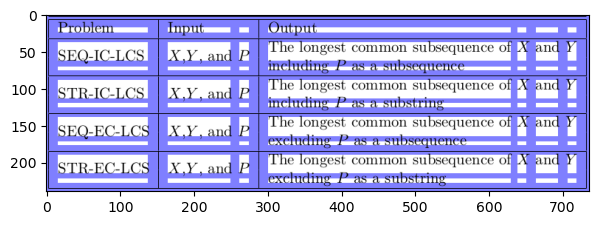

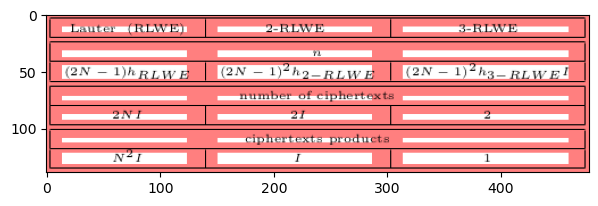

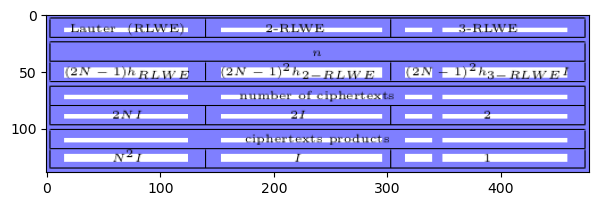

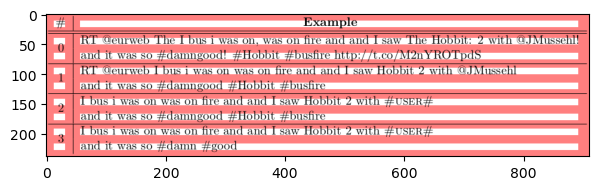

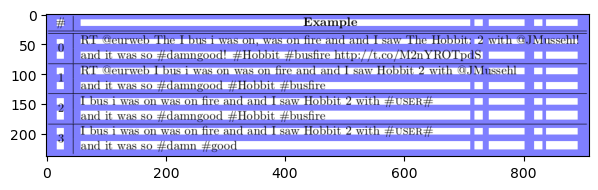

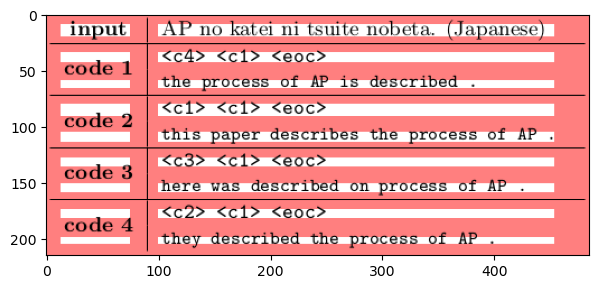

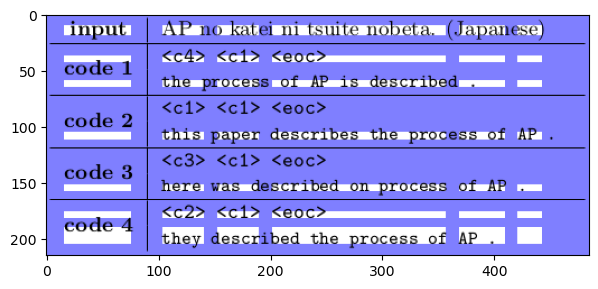

In [12]:
@torch.no_grad
def save_top_n(model, part_dir, img_names, save_dir, view=True):
    os.makedirs(save_dir, exist_ok=True)
    split_labels = load_json(os.path.join(part_dir, 'label', 'split_label.json'))
    for name in img_names:
        this_dir = os.path.join(save_dir, name)
        os.makedirs(this_dir, exist_ok=True)
        img_path = os.path.join(part_dir, 'img', f'{name}.png')
        img = load_image(img_path)
        label = split_labels[name]
        
        # save ground truth image
        r, c = np.array(label['rows']), np.array(label['columns'])
        img_gt = vis_split(img, r, c, 'red', view)
        cv.imwrite(
            os.path.join(this_dir, 'gt.png'),
            cv.cvtColor(img_gt, cv.COLOR_RGB2BGR)
        )
        
        # save prediction image
        img_ready = prep_image(img)
        r_pred, c_pred = model(img_ready)
        r_pred, c_pred = process_split_results(r_pred, c_pred)
        r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)
        img_pred = vis_split(img, r_pred, c_pred, 'blue', view)
        cv.imwrite(
            os.path.join(this_dir, 'pred.png'),
            cv.cvtColor(img_pred, cv.COLOR_RGB2BGR)
        )

# val_dir = os.path.join(SCITSR_PATH, 'val')
# save_top_n(model, val_dir, row_names, os.path.join(SAVE_PATH, 'row'))

sp = '/home/longhoang01/Developer/table-recognition/results'
train_dir = os.path.join(SCITSR_PATH, 'train')
save_top_n(model, train_dir, names, os.path.join(sp, 'split2'))

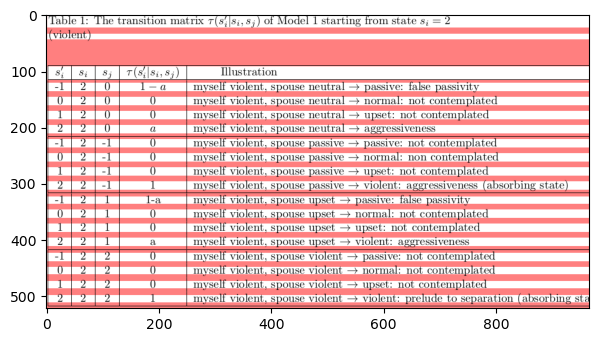

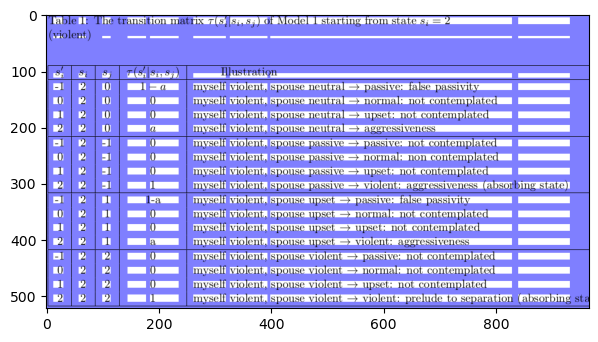

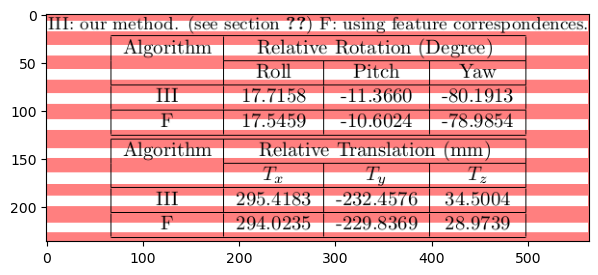

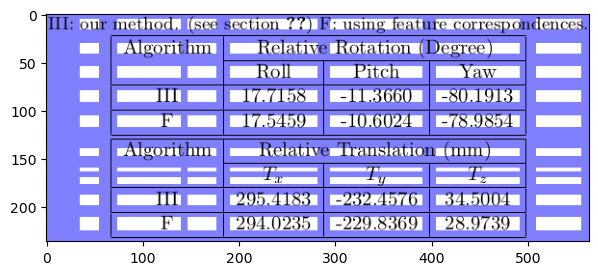

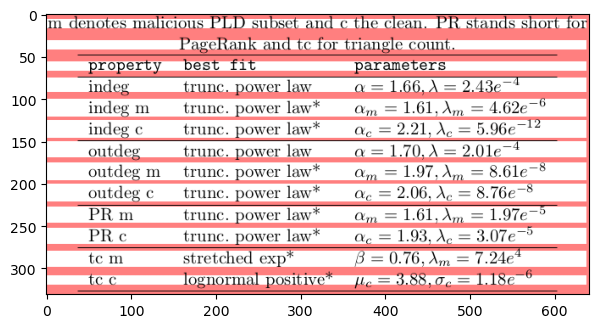

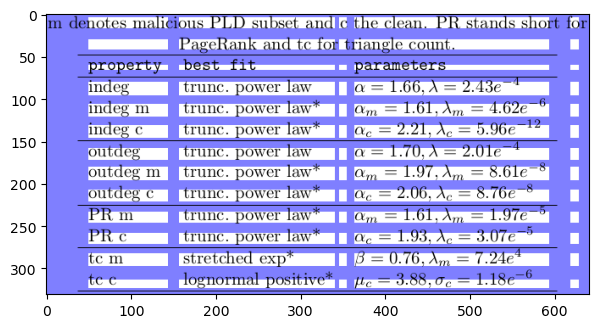

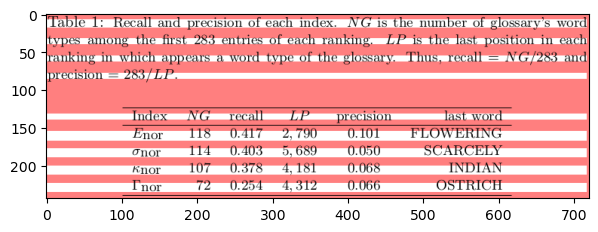

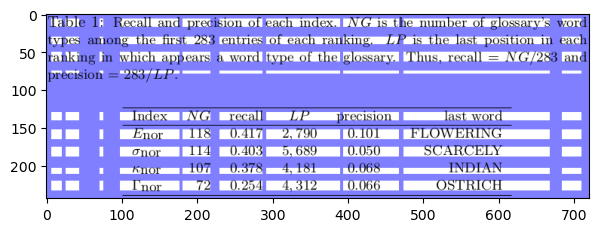

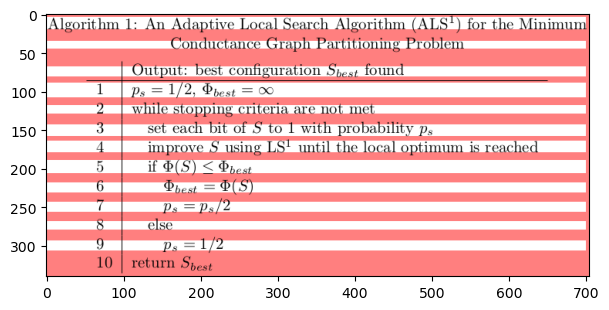

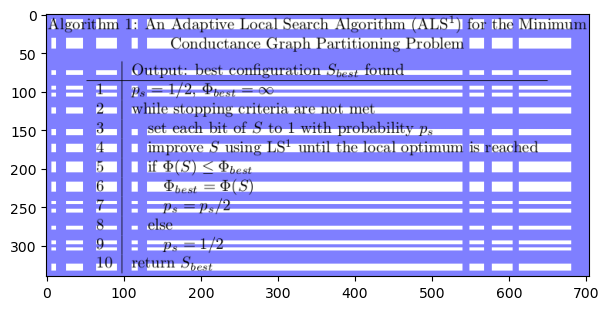

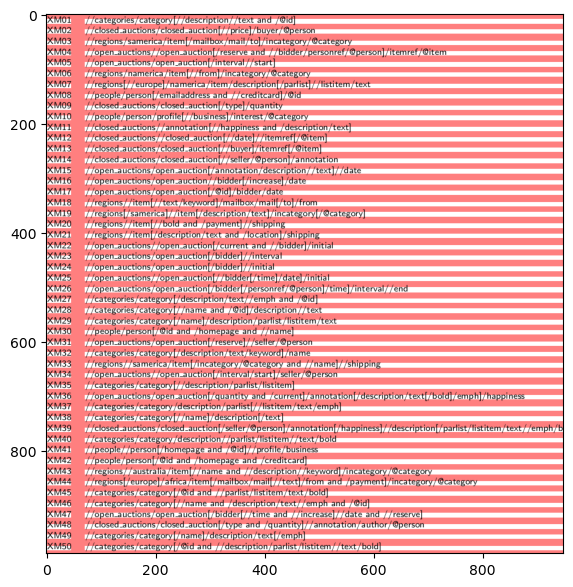

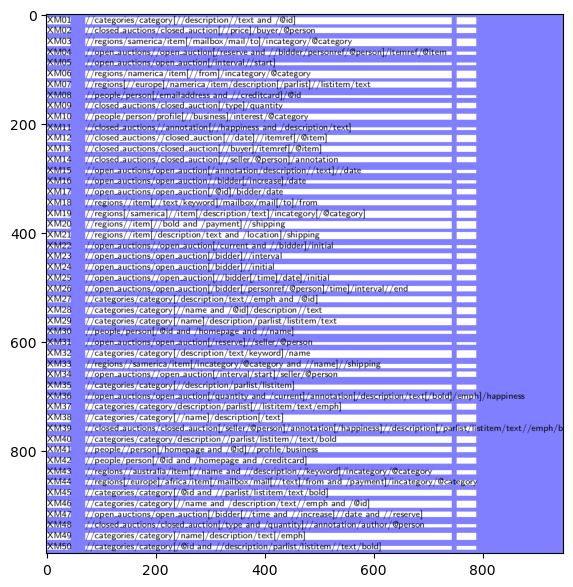

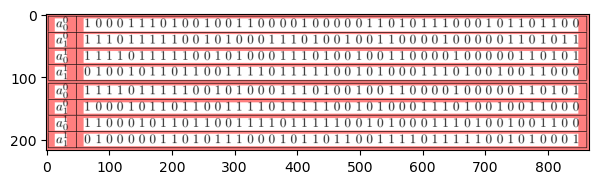

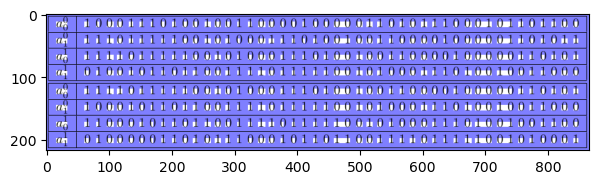

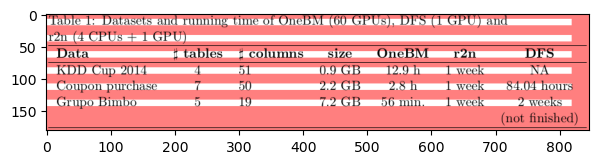

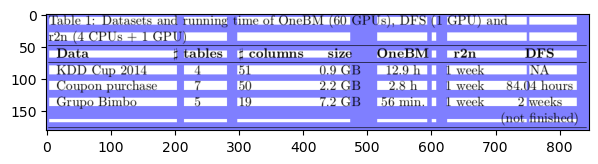

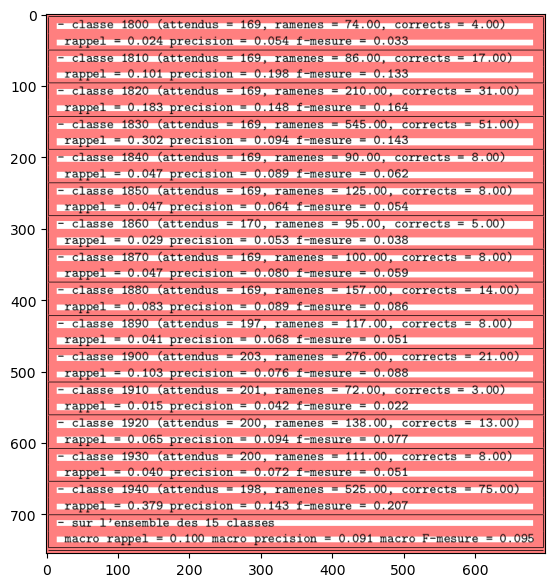

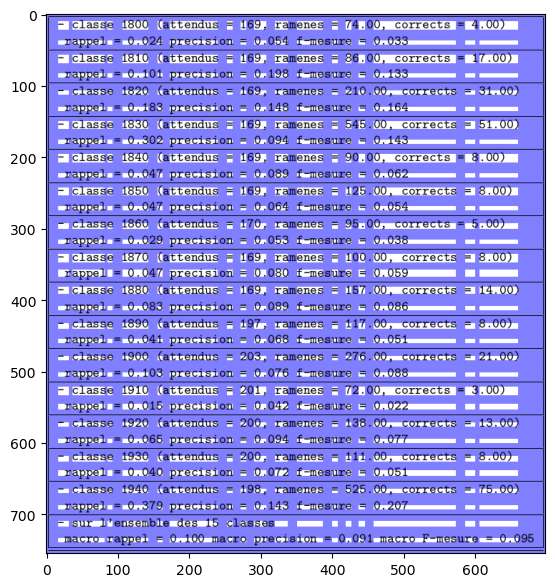

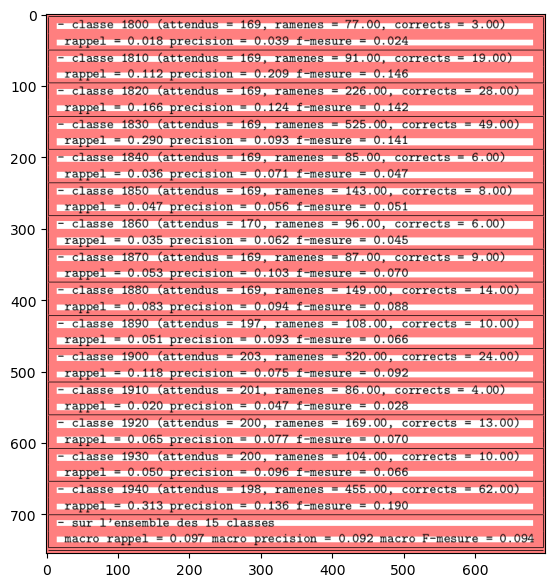

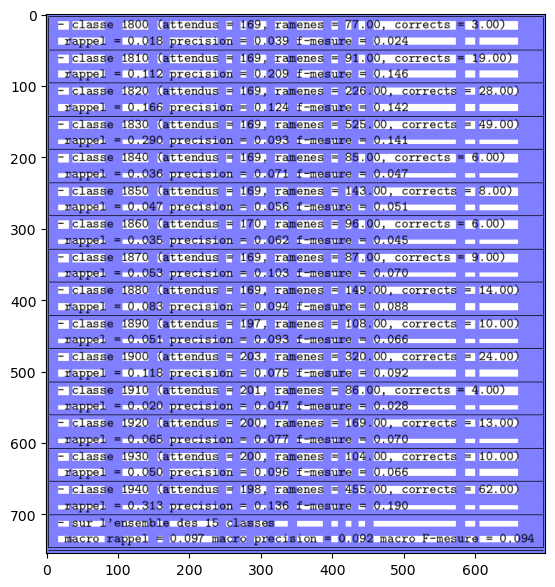

In [36]:
save_top_n(model, val_dir, col_names, os.path.join(SAVE_PATH, 'col'))

In [3]:
p = '/home/longhoang01/Developer/table-recognition/results/split/split_output_val.json'
data = load_json(p)

In [8]:
for key, val in data.items():
    print(val)
    break

{'row': {'prec': 1.0, 'rec': 0.9285714285714286, 'f1': 0.962962962962963}, 'col': {'prec': 0.8099547511312217, 'rec': 0.988950276243094, 'f1': 0.8905472636815921}}


In [ ]:
mean()